## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/l1_l2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0805 23:42:51.057214  6092 deprecation_wrapper.py:119] From C:\Python\V3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0805 23:42:51.064198  6092 deprecation_wrapper.py:119] From C:\Python\V3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 23:42:51.161935  6092 deprecation_wrapper.py:119] From C:\Python\V3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 23:42:51.165925  6092 deprecation_wrapper.py:119] From C:\Python\V3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 23:42:51.173904  6092 deprecation_wrapper.py:119] From C:\Python\V3\li

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0805 23:42:51.423157  6092 deprecation.py:323] From C:\Python\V3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 163us/step - loss: 198.7912 - acc: 0.2363 - val_loss: 41.2093 - val_acc: 0.2628
Epoch 2/20
50000/50000 [==============================] - 7s 148us/step - loss: 19.2047 - acc: 0.1229 - val_loss: 7.3482 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 7s 145us/step - loss: 4.1421 - acc: 0.0979 - val_loss: 2.6562 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 7s 148us/step - loss: 2.4877 - acc: 0.0990 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 7s 148us/step - loss: 2.4626 - acc: 0.0963 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 8s 152us/step - loss: 2.4626 - acc: 0.0958 - val_loss: 2.462

50000/50000 [==============================] - 8s 155us/step - loss: 1.6529 - acc: 0.4218 - val_loss: 1.6425 - val_acc: 0.4211
Epoch 5/20
50000/50000 [==============================] - 8s 156us/step - loss: 1.6064 - acc: 0.4381 - val_loss: 1.6001 - val_acc: 0.4409
Epoch 6/20
50000/50000 [==============================] - 8s 155us/step - loss: 1.5685 - acc: 0.4502 - val_loss: 1.5729 - val_acc: 0.4467
Epoch 7/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.5375 - acc: 0.4618 - val_loss: 1.5402 - val_acc: 0.4593
Epoch 8/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.5078 - acc: 0.4708 - val_loss: 1.5256 - val_acc: 0.4634
Epoch 9/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.4811 - acc: 0.4785 - val_loss: 1.5311 - val_acc: 0.4550
Epoch 10/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.4561 - acc: 0.4883 - val_loss: 1.4873 - val_acc: 0.4711
Epoch 11/20
50000/50000 [===================

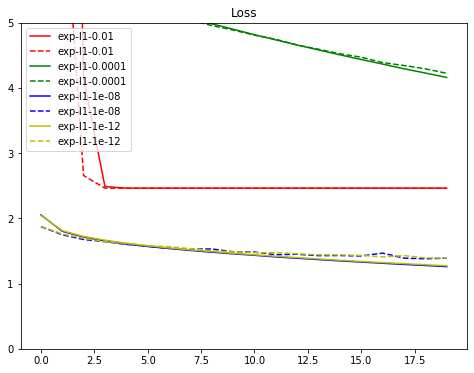

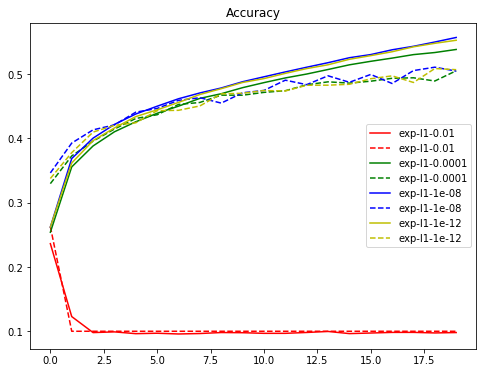

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
l1_l2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/l1_l2 的模型並訓練
"""
for regulizer_ratio in l1_l2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 212us/step - loss: 15.1053 - acc: 0.2670 - val_loss: 13.9725 - val_acc: 0.3447
Epoch 2/20
50000/50000 [==============================] - 11s 227us/step - loss: 13.0288 - acc: 0.3566 - val_loss: 12.1303 - val_acc: 0.3717
Epoch 3/20
50000/50000 [==============================] - 10s 196us/step - loss: 11.3495 - acc: 0.3808 - val_loss: 10.5958 - val_acc: 0.3951
Epoch 4/20
50000/50000 [==============================] - 11s 212us/step - loss: 9.9358 - acc: 0.3963 - val_loss: 9.2959 - val_acc: 0.4054
Epoch 5/20
50000/50000 [==============================] - 11s 213us/step - loss: 8.7356 - acc: 0.4059 - val_loss: 8.1932 - val_acc: 0.4119
Epoch 6/20
50000/50000 [==============================] - 10s 193us/step - loss: 7.7128 - acc: 0.4144 - val_loss: 7.2537 - val_acc: 0.4169
Epoch 7/20
50000/50000 [==============================] - 10s 193us/step - loss: 6.8408 - acc: 0.4196 - val_lo

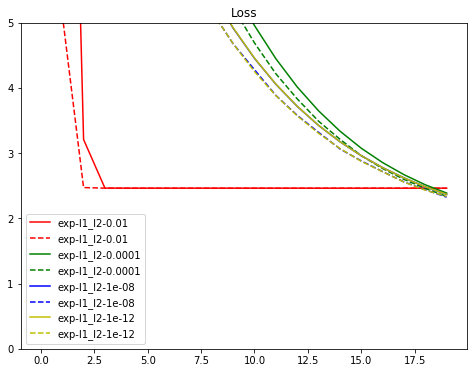

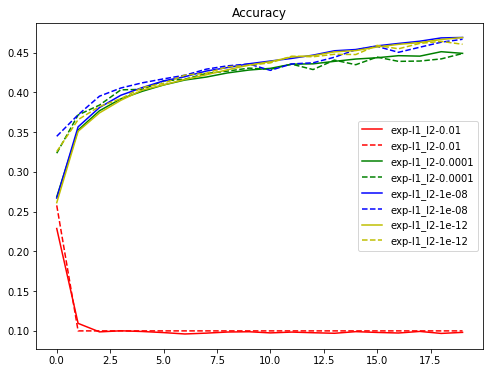

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()